In [1]:
import torch
import warnings
import pandas as pd
import numpy as np
import nltk
import pymorphy3
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from tqdm import tqdm
from phik import phik_matrix
from scipy.sparse import csr_matrix, vstack

# Load data

In [2]:
df = pd.read_csv('total_df_10%.csv')
df = df[['vacancy_id', 'vacancy_description', 'resume_id', 'resume_last_experience_description', 'target']]
# vacancy_list = df['vacancy_id'].unique().tolist()
# vacancy_list = vacancy_list[:10]
# df = df[df['vacancy_id'].isin(vacancy_list)]
#df.to_csv('description_df.csv', index=False)

In [3]:
#df = pd.read_csv('description_df.csv')

In [4]:
df.shape

(332330, 5)

## Common functions

In [5]:
# Предобработка данных
def preprocess_data(df):
    """Обработка пропущенных значений в текстовых полях"""
    print("Проверка пропущенных значений...")
    print(f"Пропуски в vacancy_description: {df['vacancy_description'].isna().sum()}")
    print(f"Пропуски в resume_last_experience_description: {df['resume_last_experience_description'].isna().sum()}")
    
    # Заполняем пропуски пустыми строками
    df['vacancy_description'] = df['vacancy_description'].fillna('')
    df['resume_last_experience_description'] = df['resume_last_experience_description'].fillna('')
    
    # Проверяем, что все значения теперь строковые
    df['vacancy_description'] = df['vacancy_description'].astype(str)
    df['resume_last_experience_description'] = df['resume_last_experience_description'].astype(str)
    
    return df

In [6]:
# Сохранение результатов
def save_results(df, output_file):
    """Сохранение результатов в CSV файл"""
    df.to_csv(output_file, index=False, encoding='utf-8')
    print(f"Результаты сохранены в файл: {output_file}")

In [7]:
# Вычисление косинусного сходства
def calculate_cosine_similarity(embeddings1, embeddings2):
    """Вычисление косинусного сходства между двумя наборами эмбеддингов"""
    similarities = []
    
    for i in tqdm(range(embeddings1.shape[0])):
        emb1_row = embeddings1[i]
        emb2_row = embeddings2[i]
        
        similarity = cosine_similarity(emb1_row, emb2_row)[0][0]
        similarities.append(similarity)
    
    return similarities

# TF-IDF

In [8]:
warnings.filterwarnings('ignore')

# Скачиваем необходимые ресурсы NLTK
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('taggers/averaged_perceptron_tagger_ru')
except LookupError:
    nltk.download('averaged_perceptron_tagger_ru')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

morph = pymorphy3.MorphAnalyzer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/usov.aleksandr/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
# Функция лемматизации для русского языка
def lemmatize_russian(tokens):
    """Лемматизация русских слов"""
    lemmas = []
    for token in tokens:
        parsed = morph.parse(token)[0]  # Берем самый вероятный разбор
        lemmas.append(parsed.normal_form)
    return lemmas

In [10]:
# Токенизация текста с лемматизацией
def tokenize_and_lemmatize(text):
    """Токенизация текста с лемматизацией и удалением стоп-слов"""
    # Базовая токенизация
    tokens = simple_preprocess(text, deacc=True, min_len=2)
    
    # Удаляем стоп-слова
    stop_words = set(stopwords.words('russian') + stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Лемматизация для русских слов
    lemmatized_tokens = lemmatize_russian(tokens)
    
    return lemmatized_tokens

In [11]:
# Токенизация для TF-IDF (возвращает строку с лемматизированными токенами)
def tokenize_for_tfidf(text):
    """Токенизация для TF-IDF с лемматизацией"""
    tokens = tokenize_and_lemmatize(text)
    return tokens

In [12]:
# Создание TF-IDF эмбеддингов с лемматизацией
def get_tfidf_embeddings(texts, vectorizer=None, fit=True):
    """Создание TF-IDF эмбеддингов для списка текстов с лемматизацией"""
    if fit:
        vectorizer = TfidfVectorizer(
            max_features=5000,
            min_df=2,
            max_df=0.8,
            ngram_range=(1, 2),
            tokenizer=tokenize_for_tfidf,
            token_pattern=None,
            lowercase=False  # Уже сделано в токенизации
        )
        embeddings = vectorizer.fit_transform(texts)
    else:
        embeddings = vectorizer.transform(texts)
    
    return embeddings, vectorizer

In [13]:
# Создание эмбеддингов для уникальных вакансий с лемматизацией
def get_tfidf_vacancy_embeddings(df, vectorizer=None):
    """Создание эмбеддингов для уникальных вакансий с лемматизацией"""
    unique_vacancies = df[['vacancy_id', 'vacancy_description']].drop_duplicates()
    
    unique_embeddings, vectorizer = get_tfidf_embeddings(
        unique_vacancies['vacancy_description'].tolist(), 
        vectorizer=vectorizer, 
        fit=(vectorizer is None)
    )
    
    # Создаем mapping: vacancy_id -> sparse row
    vacancy_embedding_dict = dict(zip(unique_vacancies['vacancy_id'], unique_embeddings))
    
    rows = []
    for vid in df['vacancy_id']:
        rows.append(vacancy_embedding_dict[vid])
    
    # Объединяем в одну sparse матрицу
    all_vacancy_embeddings = vstack(rows)
    
    return all_vacancy_embeddings, vectorizer

In [14]:
# Основная функция обработки для TF-IDF с лемматизацией
def process_similarity_scores_tfidf(df):
    """Функция для вычисления схожести с использованием TF-IDF и лемматизации"""    
    # Предобработка данных
    df = preprocess_data(df)
    
    # создание эмбеддингов для вакансий
    vacancy_embeddings, tfidf_vectorizer = get_tfidf_vacancy_embeddings(df)
    
    print("Создание TF-IDF эмбеддингов для описаний опыта в резюме...")
    experience_embeddings, _ = get_tfidf_embeddings(df['resume_last_experience_description'].tolist(), vectorizer=tfidf_vectorizer, fit=False)
    
    print("Вычисление косинусного сходства...")
    similarity_scores = calculate_cosine_similarity(vacancy_embeddings, experience_embeddings)
    
    # Добавляем scores в DataFrame
    df['similarity_score_tfidf'] = similarity_scores
    
    return df

In [15]:
df_tfidf = process_similarity_scores_tfidf(df.copy())
save_results(df_tfidf, 'description_df_with_scores_tfidf.csv')

Проверка пропущенных значений...
Пропуски в vacancy_description: 0
Пропуски в resume_last_experience_description: 8232
Создание TF-IDF эмбеддингов для описаний опыта в резюме...
Вычисление косинусного сходства...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 332330/332330 [03:19<00:00, 1668.89it/s]


Результаты сохранены в файл: description_df_with_scores_tfidf.csv


# Word2Vec

In [16]:
# Создание Word2Vec модели с лемматизацией
def train_word2vec_model(texts, vector_size=100, window=5, min_count=2):
    """Обучение Word2Vec модели на лемматизированных текстах"""
    print("Токенизация и лемматизация текстов для Word2Vec...")
    tokenized_texts = [tokenize_and_lemmatize(text) for text in tqdm(texts)]
    
    # Фильтруем пустые документы
    tokenized_texts = [tokens for tokens in tokenized_texts if len(tokens) > 0]
    
    print(f"Обучение Word2Vec модели на {len(tokenized_texts)} документах...")
    model = Word2Vec(
        sentences=tokenized_texts,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=4,
        sg=1,
        epochs=10
    )
    
    model.build_vocab(tokenized_texts, update=False)
    
    return model, tokenized_texts

In [17]:
# Создание SPARSE Word2Vec эмбеддингов
def get_word2vec_embeddings_sparse(texts, model, vocab_dict, vector_size=100):
    """Создание sparse Word2Vec эмбеддингов для списка текстов"""
    
    embeddings_data = []
    embeddings_indices = []
    embeddings_indptr = [0]
    
    for text in tqdm(texts):
        tokens = tokenize_and_lemmatize(text)
        word_indices = []
        word_weights = []
        
        for token in tokens:
            if token in vocab_dict:
                word_indices.append(vocab_dict[token])
                word_weights.append(1.0)  # Можно использовать TF или TF-IDF веса
        
        embeddings_data.extend(word_weights)
        embeddings_indices.extend(word_indices)
        embeddings_indptr.append(len(embeddings_data))
    
    # Создаем sparse матрицу
    embeddings = csr_matrix(
        (embeddings_data, embeddings_indices, embeddings_indptr),
        shape=(len(texts), len(vocab_dict))
    )
    
    return embeddings

In [18]:
# Оптимизированная функция для создания SPARSE эмбеддингов вакансий для Word2Vec
def get_word2vec_vacancy_embeddings_sparse(df, word2vec_model, vocab_dict):
    """Создание sparse эмбеддингов для уникальных вакансий"""
    # Получаем уникальные вакансии
    unique_vacancies = df[['vacancy_id', 'vacancy_description']].drop_duplicates()
    print(f"Найдено {len(unique_vacancies)} уникальных вакансий")

    # Создаем sparse эмбеддинги для уникальных вакансий
    unique_embeddings_sparse = get_word2vec_embeddings_sparse(
        unique_vacancies['vacancy_description'].tolist(), 
        word2vec_model, 
        vocab_dict
    )
    
    # Создаем словарь для быстрого доступа: vacancy_id -> sparse embedding
    vacancy_embedding_dict = {}
    for idx, vid in enumerate(unique_vacancies['vacancy_id']):
        vacancy_embedding_dict[vid] = unique_embeddings_sparse[idx]
    
    # Создаем маппинг для всего датасета как sparse матрицу
    embedding_rows = []
    for vid in df['vacancy_id']:
        embedding_rows.append(vacancy_embedding_dict[vid])
    
    all_vacancy_embeddings = vstack(embedding_rows)
    
    return all_vacancy_embeddings, word2vec_model

In [19]:
# Основная функция обработки для Word2Vec со sparse матрицами (исправленная)
def process_similarity_scores_word2vec_sparse(df):
    """Функция для вычисления схожести с использованием Word2Vec и sparse матриц"""    
    # Предобработка данных
    df = preprocess_data(df)
    
    # Объединяем все тексты для обучения Word2Vec
    all_texts = pd.concat([
        df['vacancy_description'].drop_duplicates(),
        df['resume_last_experience_description'].drop_duplicates()
    ]).tolist()
    
    # Обучаем Word2Vec модель
    word2vec_model, _ = train_word2vec_model(all_texts)
    
    print(f"Размер словаря Word2Vec: {len(word2vec_model.wv.key_to_index)}")
    
    # Создаем словарь для маппинга слов в индексы
    vocab_dict = {word: idx for idx, word in enumerate(word2vec_model.wv.key_to_index.keys())}
    
    print("Создание sparse Word2Vec эмбеддингов для вакансий...")
    # Используем исправленную функцию с sparse матрицами
    vacancy_embeddings_sparse, _ = get_word2vec_vacancy_embeddings_sparse(
        df, 
        word2vec_model, 
        vocab_dict
    )
    
    print("Создание sparse Word2Vec эмбеддингов для описаний опыта...")
    experience_embeddings_sparse = get_word2vec_embeddings_sparse(
        df['resume_last_experience_description'].tolist(), 
        word2vec_model, 
        vocab_dict
    )
    
    print("Вычисление косинусного сходства...")
    similarity_scores = calculate_cosine_similarity(
        vacancy_embeddings_sparse, 
        experience_embeddings_sparse
    )
    
    # Добавляем scores в DataFrame
    df['similarity_score_word2vec'] = similarity_scores
    
    return df

In [20]:
df_word2vec = process_similarity_scores_word2vec_sparse(df.copy())
save_results(df_word2vec, 'description_df_with_scores_word2vec.csv')

Проверка пропущенных значений...
Пропуски в vacancy_description: 0
Пропуски в resume_last_experience_description: 8232
Токенизация и лемматизация текстов для Word2Vec...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23521/23521 [03:09<00:00, 124.18it/s]


Обучение Word2Vec модели на 23493 документах...
Размер словаря Word2Vec: 37080
Создание sparse Word2Vec эмбеддингов для вакансий...
Найдено 3409 уникальных вакансий


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3409/3409 [01:16<00:00, 44.81it/s]


Создание sparse Word2Vec эмбеддингов для описаний опыта...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 332330/332330 [34:47<00:00, 159.21it/s]


Вычисление косинусного сходства...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 332330/332330 [03:36<00:00, 1535.05it/s]


Результаты сохранены в файл: description_df_with_scores_word2vec.csv


# Transformers

In [21]:
# Инициализация модели для эмбеддингов
def initialize_model(model_name='sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'):
    """Инициализация токенизатора и модели"""
    print("Инициализация модели...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    return tokenizer, model

In [22]:
# Создание sparse эмбеддингов для Transformers
def get_transformer_embeddings_sparse(texts, tokenizer, model, batch_size=8, sparsity_threshold=0.01):
    """Создание sparse эмбеддингов для списка текстов"""
    from scipy.sparse import csr_matrix
    import gc
    
    all_embeddings = []
    
    # Фильтруем пустые тексты
    processed_texts = []
    for text in texts:
        if isinstance(text, (str, np.str_)) and len(text.strip()) > 0:
            processed_texts.append(text.strip())
        else:
            processed_texts.append(" ")
    
    print(f"Обрабатывается {len(processed_texts)} текстов...")
    
    for i in tqdm(range(0, len(processed_texts), batch_size)):
        batch_texts = processed_texts[i:i+batch_size]
        
        try:
            # Токенизация
            encoded_input = tokenizer(
                batch_texts, 
                padding=True, 
                truncation=True, 
                max_length=512, 
                return_tensors='pt'
            )
            
            # Получение эмбеддингов
            with torch.no_grad():
                model_output = model(**encoded_input)
                embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
                batch_embeddings = embeddings.cpu().numpy()
                
                # Преобразуем в sparse
                for emb in batch_embeddings:
                    sparse_emb = csr_matrix(emb)
                    # Применяем порог sparsity
                    sparse_emb.data[np.abs(sparse_emb.data) < sparsity_threshold] = 0
                    sparse_emb.eliminate_zeros()
                    all_embeddings.append(sparse_emb)
                
        except Exception as e:
            print(f"Ошибка при обработке батча {i}: {e}")
            # Добавляем нулевые sparse эмбеддинги для проблемного батча
            for _ in range(len(batch_texts)):
                all_embeddings.append(csr_matrix((1, model.config.hidden_size)))
        
        # Очищаем память
        if i % (batch_size * 5) == 0:
            gc.collect()
    
    # Объединяем все sparse матрицы в одну большую sparse матрицу
    from scipy.sparse import vstack
    final_embeddings = vstack(all_embeddings)
    
    return final_embeddings

In [23]:
# Функция для усреднения эмбендингов
def mean_pooling(model_output, attention_mask):
    """Mean Pooling - берем среднее значение скрытых состояний"""
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [24]:
# Оптимизированная функция для создания SPARSE эмбеддингов вакансий для Transformers
def get_vacancy_embeddings_transformer_sparse(df, tokenizer, model, sparsity_threshold=0.01):
    """Создание sparse эмбеддингов для уникальных вакансий"""
    # Получаем уникальные вакансии
    unique_vacancies = df[['vacancy_id', 'vacancy_description']].drop_duplicates()
    print(f"Найдено {len(unique_vacancies)} уникальных вакансий")
    
    # Создаем sparse эмбеддинги только для уникальных вакансий
    print("Создание sparse эмбеддингов для уникальных вакансий...")
    unique_embeddings_sparse = get_transformer_embeddings_sparse(
        unique_vacancies['vacancy_description'].tolist(), 
        tokenizer, 
        model,
        sparsity_threshold=sparsity_threshold
    )
    
    # Создаем словарь для быстрого доступа: vacancy_id -> sparse embedding
    vacancy_embedding_dict = {}
    for idx, vid in enumerate(unique_vacancies['vacancy_id']):
        vacancy_embedding_dict[vid] = unique_embeddings_sparse[idx]
    
    # Создаем маппинг для всего датасета как sparse матрицу
    from scipy.sparse import vstack
    embedding_rows = []
    for vid in df['vacancy_id']:
        embedding_rows.append(vacancy_embedding_dict[vid])
    
    all_vacancy_embeddings = vstack(embedding_rows)
    
    return all_vacancy_embeddings

In [25]:
# Основная функция обработки для Transformers со sparse матрицами (исправленная)
def process_similarity_scores_transformer_sparse(df, tokenizer, model):
    """Оптимизированная функция для вычисления схожести с использованием Transformers и sparse матриц"""
    # Предобработка данных
    df = preprocess_data(df)
    
    # Оптимизированное создание sparse эмбеддингов для вакансий
    print("Создание sparse эмбеддингов для вакансий...")
    vacancy_embeddings = get_vacancy_embeddings_transformer_sparse(
        df, 
        tokenizer, 
        model
    )
    
    print("Создание sparse эмбеддингов для описаний опыта в резюме...")
    experience_embeddings = get_transformer_embeddings_sparse(
        df['resume_last_experience_description'].tolist(), 
        tokenizer, 
        model
    )
    
    print("Вычисление косинусного сходства...")
    similarity_scores = calculate_cosine_similarity(
        vacancy_embeddings, 
        experience_embeddings
    )
    
    # Добавляем scores в DataFrame
    df['similarity_score_transformer'] = similarity_scores
    
    return df

In [26]:
model_name = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
tokenizer, model = initialize_model(model_name)

# Вычисление схожести
df_transformer = process_similarity_scores_transformer_sparse(df, tokenizer, model)

Инициализация модели...
Проверка пропущенных значений...
Пропуски в vacancy_description: 0
Пропуски в resume_last_experience_description: 8232
Создание sparse эмбеддингов для вакансий...
Найдено 3409 уникальных вакансий
Создание sparse эмбеддингов для уникальных вакансий...
Обрабатывается 3409 текстов...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 427/427 [08:23<00:00,  1.18s/it]


Создание sparse эмбеддингов для описаний опыта в резюме...
Обрабатывается 332330 текстов...


 47%|████████████████████████████████████████████████████████████                                                                    | 19476/41542 [4:43:48<5:45:03,  1.07it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [27]:
df = df.merge(df_tfidf).merge(df_word2vec).merge(df_transformer)

In [28]:
df

,vacancy_id,vacancy_description,resume_id,resume_last_experience_description,target,similarity_score_transformer,similarity_score_tfidf,similarity_score_word2vec
0,126167948,"Привет!.redev — технологическая компания, созд...",6969174,Участие в проектах:\r\nСибинтек (SAP MDG (Mast...,1,0.386884,0.354339,0.516185
1,126167948,"Привет!.redev — технологическая компания, созд...",9100077,"SAP S/4HANA (BTP, RAP, CDS, AMDP, ODATA V4, FI...",1,0.460611,0.472020,0.369648
2,126167948,"Привет!.redev — технологическая компания, созд...",32644957,ABAP-разработчик (SAP Solution Manager)\n•\tУч...,1,0.438212,0.633376,0.743483
3,126167948,"Привет!.redev — технологическая компания, созд...",27220466,Внедрение SAP ISU в МРСК-Сибири.\r\nМиграция д...,1,0.369321,0.435246,0.507833
4,126167948,"Привет!.redev — технологическая компания, созд...",7532708,Projects:\r\nParticipated in 9 projects in Rus...,1,0.215726,0.137066,0.082912
...,...,...,...,...,...,...,...,...
332325,125547086,Мы — Wildberries. Мы — это крупнейший маркетпл...,255135,Достижения:\r\n•Сформировала отдел управления ...,0,0.707073,0.041374,0.297626
332326,125547086,Мы — Wildberries. Мы — это крупнейший маркетпл...,34423776,.,0,0.330166,0.000000,0.000000
332327,125547086,Мы — Wildberries. Мы — это крупнейший маркетпл...,54564265,- Формирование и руководство отделом интернет ...,0,0.668410,0.030688,0.207074
332328,125547086,Мы — Wildberries. Мы — это крупнейший маркетпл...,70588832,- Анализ научной литературы\r\n- Подготовка на...,0,0.391920,0.018629,0.086176


interval columns not set, guessing: ['target', 'similarity_score_tfidf', 'similarity_score_word2vec', 'similarity_score_transformer']


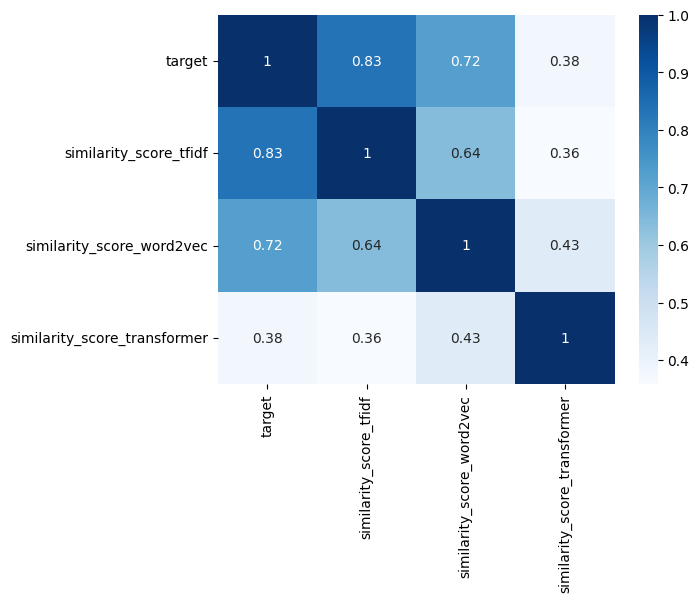

In [29]:
sns.heatmap(phik_matrix(df[['target', 'similarity_score_tfidf', 'similarity_score_word2vec', 'similarity_score_transformer']]), cmap='Blues', annot=True);